# 实验 8 交易程序设计

## 背景介绍：

在上一部分的实验中，我们已经学会了如何求得我们的股票持仓。 那么，我们可以直接把这个持仓用在交易中。 目前，我国股票程序化交易的合规性尚不明确， 故我们也建议大家在选出股票后手工交易。 毕竟，国内外主流的做法还是每周换仓/每月换仓， 日度换仓的都相对较少，更遑论日内了。 所以，用程序交易股票，也必要性不大。

所以，原则上，到上一部分为止， 读者已经可以在我们的指引下完成量化投资的全部流程了。但我们还是希望读者能够一窥程序交易的梗概。 故在最后一部分中，我们将简要介绍交易程序的设计问题。

不过，限于篇幅，我们无法去呈现一个完整的交易程序，故我们择其重点加以介绍。有兴趣的同学经过对本章的阅读，是一定可以独立写出交易程序的。

## 实验过程：

1. 学习交易所提供的基于C++的API
2. 学习一个基于Python的API——QuickLib
3. 学习Python的面向对象编程
3. 完成交易策略状态机

## 实验目标：

1. 了解c++和python的区别
2. 初步了解如何调用API和查询官方文档
3. 掌握API和面向对象编程的思想

## 预期结果：

做到可以初步进行API的调用，完成交易程序

## 作业

使用交易程序对最近的股市中的某一股票进行分析，看看程序的结果能不能在未来的走势中获利

## 8.1 基础知识储备

交易程序大致分为三部分——交易接口、数据储存、交易逻辑。

交易接口是我们的程序和交易所相联系的枢纽。交易所告诉我们，调用什么样的函数可以报撤单，调用什么样的函数可以查询信息。而这些都是交易接口的内容。在本章中，我们将学习交易所提供过的基于C++的交易接口。另外，我们还将介绍一个第三方提供的基于Python的免费交易接口。它其实就是在内部将交易所提供的接口封装了一下，在外部提供Python的函数以供调用。

数据储存则包括两部分：储存机制、数据结构。储存机制讨论的是——我收到数据后，是存在内存还是硬盘，是堆还是栈，分布式储存还是集中储存，以何种格式储存。而数据结构则是讨论——我储存时以怎样的结构储存，以便在储存、访问、运算之间搭起一座桥梁。这几点并不是特别重要，有些交易接口已经将数据的储存集成了进去，并不太需要我们去操心。

交易逻辑则是策略的核心，它一定是一个状态机，描述了状态集合、状态间转移的条件、状态间转移时需要执行的动作。这就对应了当前的交易状态、交易状态变化的条件、交易状态变化时需要执行的操作。我们会对此进行详细的介绍，并一起完成一个模拟交易的程序。在此过程中，我们将涉及Python的面向对象编程，我们先简单介绍一下。

## 8.2 操作流程

### 8.2.1 步骤一：学习交易所提供的基于C++的API

ctp是上海期货交易所旗下的上海期货信息技术有限公司（下称上期技术) 开发的综合交易平台的简称。 上期技术免费提供ctp接口—— 即是基于c++的一些头文件和动态链接库。 它给我们提供了一些函数， 只要我们调用这些函数，就可以完成和交易所的通信： 包括行情接收、账户查询、报单撤单等等。

由于接口基于c++，内容也比较多， 我们就选择重要的函数来解释一下它的运行机制， 而并不详细讨论。

ctp接口提供了4个重要的类：
行情Spi、行情Api、交易Spi、交易Api。

其中，Spi类是一个基类，我们需要从它派生出一个类，
继承它所提供的函数，并完成这些函数的内容。
这些函数都是回调函数，实际运行时，
是有交易所发起调用这些函数，并以参数形式传递必要的信息给我们，
而函数被调用时，我们就可以执行相应的动作，作为响应。

Api类则包含一些需要我们来主动执行的函数，
比如主动连接行情和交易前置，以及诸多查询函数。

下面我们先来看看行情Spi类：

In [1]:
#这是C++代码，在Python环境下无法运行，这里只是介绍其代码
class CThostFtdcMdSpi
{
    #行情前置连接成功时ctp调用
    virtual void OnFrontConnected(){};
    #ctp收到登录请求时的调用，登录成功与否以参数形式传入。
    virtual void OnRspUserLogin(...){};
    #ctp收到订阅行情的请求时调用
    virtual void OnRspSubMarketData(...){};
    #ctp推送行情数据时调用，行情数据以参数形式传入。
    virtual void OnRtnDepthMarketData(...){};
    ...
};

SyntaxError: invalid syntax (<ipython-input-1-75927e940897>, line 2)

行情Spi类的函数非常清晰，我们再看看行情Api类：

In [ ]:
#这是C++代码，在Python环境下无法运行，这里只是介绍其代码
class MD_API_EXPORT CThostFtdcMdApi
{
    #初始化系统，尝试连接行情前置
    virtual void Init();
    #将我们定义的派生类注册到ctp，实际就是加入一个等待调用的列表。
    virtual void RegisterSpi(...);
    #订阅行情
    virtual int SubscribeMarketData(...);
    #请求登录
    virtual int ReqUserLogin(...);
    ...
};

行情相关的这两个类简单且清晰，我们接下来看交易相关的两个类：

In [ ]:
class CThostFtdcTraderSpi
{
public:
    virtual void OnFrontConnected(){};
    virtual void OnRspUserLogin(){};
    #ctp收到报单请求时调用
    virtual void OnRspOrderInsert(){};
    #ctp收到投资者结算单查询请求时调用，结算单以参数形式传入
    virtual void OnRspQrySettlementInfo(){};
    #ctp通知报单状态更新
    virtual void OnRtnOrder(){};
    #ctp通知成交状态更新
    virtual void OnRtnTrade(){};
    ...
};

class TRADER_API_EXPORT CThostFtdcTraderApi
{
public:
    virtual void Init();
    virtual void RegisterSpi(...);
    #请求认证客户端
    virtual int ReqAuthenticate(...);
    virtual int ReqUserLogin(...);
    #请求录入报单
    virtual int ReqOrderInsert(...);
    #确认结算结果
    virtual int ReqSettlementInfoConfirm(...);
    #请求查询合约
    virtual int ReqQryInstrument(...);
    ...
};

基于C++的接口很复杂，我们使用python编写交易程序时， 需要首先用python封装这四个类， 然后调用其中函数，方可完成ctp的封装和接入。 不过好在现在有了第三方的免费接口替我们封装了C++的接口，取而代之提供了Python的接口供我们使用。故我们基本可以略过C++的部分了。

### 8.2.2 步骤二：学习一个基于Python的API——QuickLib

前面说的第三方的Python接口就是QuickLib，它已经替我们完成了封装步骤，我们可以直接使用。它的官网是：

http://www.quicklib.cn/ 

读者遇到问题时可以到官网上去求助。因为股票程序化交易的合规性存疑，我们仅详细介绍其期货部分的用法。

#### 8.2.2.1 开发环境

开发环境如下：
1. Python 2.7.6  32位
2. wingide 5.1.8  IDE开发工具
3. 其他可能涉及的库
4. Python(x,y) 2.7.6 封装了常用的Pyhton库 
5. PyQt4  界面库

#### 8.2.2.2 配置文件

行情配置文件QuickLibMD.ini中填写以下字段：
1. addr：行情前置地址和端口号
2. brokeid：期货公司代码
3. userid：期货账号
4. password：密码

交易配置文件QuickLibTD.ini中填写以下字段：
1. addr：交易前置地址和端口号
2. brokerid：期货公司代码
3. userid：期货账号
4. password：密码

合约订阅、策略、仓位配置文件Instrument.ini中填写以下字段：
1. [合约数量]：
    1. num：订阅合约的个数
2. [Instrument1]：
    1. instrument：合约代码
    2. Strategy：策略ID
    3. PositionRate：仓位百分比
3. [Instrument2]：同上……

行情时间、交易时间配置文件TradeTime.ini中填写以下字段：
1. [时间段配置文件读取显示]：
    1. 是否显示读取过程：0/1
2. [合约数量]：
    1. num：需要设置行情时间和交易时间的合约品种的数量
3. [合约品种]：
    1. 合约1：合约名称
    2. 合约2：同上……
4. [xx行情]：
    1. begin1：行情时段1的开始时间，xx表示品种名
    2. end1：行情时段1的结束时间
    3. begin2：同上……
5. [xx交易]：交易时段，格式同行情时段的设置。

#### 8.2.2.3 常用库

##### 8.2.2.3.1 CTP行情库“CTPMarket.py”

订阅行情：

In [2]:
#需在8.2.2.1所述开发环境中方可运行
from CTPMarket import *
market = CTPMarket()
market.Subcribe('IF1812')
print(market.InstrumentID('IF1812'), market.LastPrice('IF1812'))

ModuleNotFoundError: No module named 'CTPMarket'

订阅行情所获得的字段有：
1. TradingDay 交易日
2. InstrumentID 合约代码
3. ExchangeID 交易所代码
4. ExchangeInstID 合约在交易所的代码
5. LastPrice 最新价
6. PreSettlementPrice 昨结算价
7. PreClosePrice 昨收盘价
8. PreOpenInterest 昨持仓量
9. OpenPrice 开盘价
10. HighestPrice 最高价
11. LowestPrice 最低价
12. Volume 成交量
13. Turnover 成交金额
14. OpenInterest 持仓量
15. ClosePrice 收盘价
16. SettlementPrice 结算价
17. UpperLimitPrice 涨停价
18. LowerLimitPrice 跌停价
19. UpdateTime 最新时间
20. UpdateMillisec 最新毫秒
21. BidPrice1-BidPrice5 买一到买五价
22. AskPrice1-AskPrice5 卖一到卖五价
23. BidVolume1-BidVolume5 买一到买五量
24. AskVolume1-AskVolume5 卖一到卖五量
25. AveragePrice 当日均价

##### 8.2.2.3.2 CTP交易库“CTPTrader.py”

下单程序：

In [ ]:
#需在8.2.2.1所述开发环境中方可运行
from CTPTrader import *
trader = CTPTrader()
retLogin = trader.Login()
ordercf = trader.InsertOrder('IF1812', YT_D_Buy, YT_OF_Open, YT_OPT_LimitPrice, market.LastPrice('IF1812'), 1)

上述代码表示，买开一手IF1812，限价LastPrice。

其函数原型为：InsertOrder(instumentID, direction, offsetFlag, priceType, price, num)

各参数取值为：
1. direction: 买卖：YT_D_Buy/YT_D_Sell
2. offsetFlag：开平：YT_OF_Open/YT_OF_Close
3. PriceType：价格类型：YT_OPT_LimitPrice/YT_OPT_BestPrice

##### 8.2.2.3.3 ini配置文件读写库“IniFile.py"

用于读写配置文件：

In [3]:
#需在8.2.2.1所述开发环境中方可运行
from IniFile import *
igr = IniGetRead()

ModuleNotFoundError: No module named 'IniFile'

该类中拥有以下方法：
读取配置文件的某个字段：read_ini(self, config_file, path, key)
更新配置文件的某个字段为val：update_ini(self, config_file, path, key, val)

### 8.2.3 步骤三：学习Python的面向对象编程

Python从设计之初就已经是一门面向对象的语言，正因为如此，在Python中创建一个类和对象是很容易的。我们先了解一些面向对象语言的一些基本特征，在头脑里头形成一个基本的面向对象的概念，这样有助于我们更容易的学习Python的面向对象编程。 

面向对象语言的基本特征：
1. 类: 用来描述具有相同的属性和方法的对象的集合。它定义了该集合中每个对象所共有的属性和方法。对象是类的实例。
2. 对象：通过类定义的数据结构实例。对象包括两个数据成员（类变量和实例变量）和方法。
3. 实例化：创建一个类的实例，类的具体对象。
4. 方法：类中定义的函数。
5. 类变量：类变量在整个实例化的对象中是公用的。类变量定义在类中且在函数体之外。类变量通常不作为实例变量使用。
6. 实例变量：定义在方法中的变量，只作用于当前实例的类。
7. 数据成员：类变量或者实例变量，用于处理类及其实例对象的相关的数据。
8. 继承：即一个派生类继承基类的字段和方法。继承也允许把一个派生类的对象作为一个基类对象对待。例如，有这样一个设计：一个Dog类型的对象派生自Animal类，这是模拟"是一个（is-a）"关系。
9. 方法重写：如果从父类继承的方法不能满足子类的需求，可以对其进行改写，这个过程叫方法的覆盖，也称为方法的重写。

和其它编程语言相比，Python 在尽可能不增加新的语法和语义的情况下加入了类机制。
Python中的类提供了面向对象编程的所有基本功能：类的继承机制允许多个基类，派生类可以覆盖基类中的任何方法，方法中可以调用基类中的同名方法。 
对象可以包含任意数量和类型的数据。 

我们先看看如何定义一个类：

In [ ]:
#定义类
class MyClass:
    #类变量
    x = 1
    #方法
    def f(self):
        return 'hello, world!'

#实例化
c = MyClass()

#调用类变量
print(c.x)
#调用类方法
print(c.f())

上面，self是一个习惯用语，它需要出现在类的方法中，作为一个参数传入。它其实就是这个类的实例。这是类方法和普通函数的唯一区别。下面，我们来定义一个稍微复杂一点的类，用以解释Python面向对象编程的更多用法。

In [4]:
#基类
class Animal:
    
    name = ''
    age = 0
    #定义私有属性，无法从外部直接访问
    __weight = 0
    __hight = 0
    
    
    #定义构造函数
    def __init__(self, n, a, w, h):
        self.name = n
        self.age = a
        self.__weight = w
        self.__hight = h
        
    #定义基类的一个方法
    def speak(self):
        pass
    
#继承——派生类
class Dog(Animal):
    
    def __init__(self, n, a, w, h):
        #调用基类的构造函数
        Animal.__init__(self, n, a, w, h)
        
    #重定义基类的一个方法
    def speak(self):
        print('wang!wang!')
    

#调用
A = Animal('abc', 3, 4, 5)
print(A.name, A.age)
A.speak()
B = Dog('ddd', 2,3,4)
print(B.name)
B.speak()

abc 3
ddd
wang!wang!


以上，我们简要介绍了Python的面向对象编程。下面我们将使用它来做更多的事情。

### 8.2.4 步骤四：完成交易策略状态机

接下来，我们着眼于如何编写交易逻辑，并完成交易程序的主体。
我们会以随机数来模拟收到的行情，触发交易程序进行决策。

以下代码都可以在本环境下运行。

首先，我们编写一个数据处理与储存类：

In [5]:
class CMarketData:
    #假设一个交易日有70个tick，以便于演示。真实情况有20000-70000个。
    TotalTick = 70 
    
    def __init__(self):
        self.Tick = -1 
        #同时调用api接口，连接行情前置，登陆账户，准备收行情
        #此处，设计数据结构以储存行情数据，由读者完成
    
    #本函数由Spi中的收行情的回调函数调用，即每次收到行情时调用一次
    def NewTickCome(self, Strategy):
        self.Tick += 1
        #整理并储存数据，由读者完成
        Strategy.Do()#这就是交易逻辑模块运行的地方

接下来，我们进入交易逻辑的核心。
首先，我们要清楚，交易逻辑实际上是一个状态机。 那么交易逻辑实际上就由三部分组成：
1. 确认有哪些状态；
2. 设置状态变迁的条件；
3. 落实状态变迁时的动作。

那么，首先，我们来看有哪些状态呢？ 以一个简单的策略为例，有： 非交易状态、等待开仓状态、开仓中、持仓中、平仓中、结束交易， 共计6个状态：

In [6]:
class CStatus:
    BeforeTrade = 1
    WaitingChance = 2
    Opening = 3
    Holding = 4
    Closing = 5
    NoTrade = 6
    
    def __init__(self):
        self.Status = self.BeforeTrade

然后，我们列举状态变迁的条件：

In [7]:
import random

class CCondition:
    
    #判断是否是我们设定的可交易时间
    def IsTradeTime(self, data):
        #收到第7个tick时可以开始交易,收盘前5个tick强制平仓。
        return data.Tick >= 7 and data.Tick <= data.TotalTick - 5 
    
    #做多信号，简单起见，以随机数代替
    def IsLongChance(self, data):
        return random.random() < 0.03
    
    #做空信号，简单起见，以随机数代替
    def IsShortChance(self, data):
        return random.random() < 0.03
    
    #平仓信号，简单起见，以随机数代替
    def IsCloseChance(self, data):
        return random.random() < 0.05
    
    #判断是否开仓成功，简单起见，默认成功
    def IsOpenSuccessfully(self, data):
        return True
    
    #判断是否平仓成功，简单起见，默认成功
    def IsCloseSuccessfully(self, data):
        return True

接下来，定义状态变迁时的动作：

In [8]:
class CAction:
    
    def OpenLong(self, Position):
        Position = 1 
        #同时调用api接口下单
        
    def OpenShort(self, Position):
        Position = -1 
        #同时调用api接口下单
        
    def Close(self, Postion):
        Position = 0 
        #同时调用api接口下单

有了上面这些准备，我们就可以写交易策略的核心逻辑了，这部分比较长，希望读者能认真读完，体会其中逻辑：

In [9]:
class CStrategy:
    
    def __init__(self, MarketData):
        self.MarketData = MarketData;
        self.Status = CStatus();
        self.Condition = CCondition();
        self.Action = CAction();
        self.Position = 0;
        #同时调用api接口，连接交易前置，登陆账户，查询并确认结算单，准备交易
        
    def Do(self):
        print("Tick = ",self.MarketData.Tick, end='')                
        if self.Status.Status == self.Status.BeforeTrade:
            print("——数据准备中",end='')           
            if self.Condition.IsTradeTime(self.MarketData):
                print("——到达可交易时段！")
                self.Status.Status = self.Status.WaitingChance
            else:
                print()                   
        elif self.Status.Status == self.Status.WaitingChance:
            print("——等待机会中", end='')            
            if not self.Condition.IsTradeTime:
                print("——快收盘了，撤！")
                self.Status.Status = self.Status.NoTrade                
            elif self.Condition.IsLongChance(self.MarketData):
                print("——机会来了，做多！")
                self.Action.OpenLong(self.Position)
                self.Status.Status = self.Status.Opening            
            elif self.Condition.IsShortChance(self.MarketData):
                print("——机会来了，做空！")
                self.Action.OpenShort(self.Position)
                self.Status.Status = self.Status.Opening
            else:
                print()             
        elif self.Status.Status == self.Status.Opening:
            print("——开仓中", end='')            
            if self.Condition.IsOpenSuccessfully(self.MarketData):
                print("——开仓成功！")
                self.Status.Status = self.Status.Holding
            else:
                print("——开仓失败！")
                self.Status.Status = self.Status.WaitingChance                
        elif self.Status.Status == self.Status.Holding:
            print("——持仓中", end='')
            if not self.Condition.IsTradeTime(self.MarketData):
                print("——快收盘了，平仓！")
                self.Action.Close(self.Position)
                self.Status.Status = self.Status.Closing
            elif self.Condition.IsCloseChance(self.MarketData):
                print("——平仓信号来了，平仓！")
                self.Action.Close(self.Position)
                self.Status.Status = self.Status.Closing
            else:
                print()                
        elif self.Status.Status == self.Status.Closing:
            print("——平仓中", end='')
            if self.Condition.IsCloseSuccessfully(self.MarketData):
                print("——平仓成功！")
                if self.Condition.IsTradeTime(self.MarketData):
                    self.Status.Status = self.Status.WaitingChance
                else:
                    self.Status.Status = self.Status.NoTrade
            else:
                print("——平仓失败！")
                self.Action.Close(self.Position)                       
        else:
            print("——禁止开仓！")

接下来，我们可以模拟收到行情数据，然后触发交易逻辑的核心部分：

In [10]:
import time
MarketData = CMarketData()
Strategy = CStrategy(MarketData)

for tick in range(MarketData.TotalTick):
    time.sleep(0.5)
    MarketData.NewTickCome(Strategy)

Tick =  0——数据准备中
Tick =  1——数据准备中
Tick =  2——数据准备中
Tick =  3——数据准备中
Tick =  4——数据准备中
Tick =  5——数据准备中
Tick =  6——数据准备中
Tick =  7——数据准备中——到达可交易时段！
Tick =  8——等待机会中
Tick =  9——等待机会中——机会来了，做多！
Tick =  10——开仓中——开仓成功！
Tick =  11——持仓中
Tick =  12——持仓中
Tick =  13——持仓中
Tick =  14——持仓中
Tick =  15——持仓中
Tick =  16——持仓中
Tick =  17——持仓中
Tick =  18——持仓中
Tick =  19——持仓中
Tick =  20——持仓中
Tick =  21——持仓中
Tick =  22——持仓中
Tick =  23——持仓中
Tick =  24——持仓中
Tick =  25——持仓中
Tick =  26——持仓中
Tick =  27——持仓中
Tick =  28——持仓中
Tick =  29——持仓中
Tick =  30——持仓中
Tick =  31——持仓中
Tick =  32——持仓中
Tick =  33——持仓中
Tick =  34——持仓中
Tick =  35——持仓中
Tick =  36——持仓中
Tick =  37——持仓中
Tick =  38——持仓中——平仓信号来了，平仓！
Tick =  39——平仓中——平仓成功！
Tick =  40——等待机会中
Tick =  41——等待机会中
Tick =  42——等待机会中
Tick =  43——等待机会中
Tick =  44——等待机会中
Tick =  45——等待机会中
Tick =  46——等待机会中
Tick =  47——等待机会中
Tick =  48——等待机会中
Tick =  49——等待机会中
Tick =  50——等待机会中
Tick =  51——等待机会中
Tick =  52——等待机会中
Tick =  53——等待机会中
Tick =  54——等待机会中
Tick =  55——等待机会中
Tick =  56——等待机会

经过了我们的模拟，我们已经体会到了一个交易程序中，策略核心逻辑的实现过程。上面例子虽然简单，但真实建议的核心程序就这么多，读者如有兴趣，可将上述代码加以完善，对接QuickLib的API，就能很容易的完成一个交易程序。

## 8.3 延伸阅读

### 8.3.1 实盘交易应注意的其它问题

实盘交易时，还有很多问题需要处理， 绝非简简单单几百行程序就能完成。 我们在此将一些容易走的弯路告诉读者， 帮助读者尽可能少走弯路。 但是，我们也希望读者能认识到： 不走弯路是无法获得提高的， 很多弯路真的需要亲自去走一走， 才能体会到其中奥妙。

1. 数据可能丢包：

我们的程序在和交易所通信时，由于网络等问题，
可能会出现丢包。那么，我们的程序如何识别丢包？
我们的程序又如何处理丢包？

2. 交易所的服务器可能突然宕机：

交易所的服务器可能会突然宕机，这是真实遇到过好几次的，
如果发生了这种情况，我们程序如何识别和处理？
需不需要和交易员通信，告知交易员，由交易员处理？

3. 交易所发的数据，可能格式有问题：

一般，我们按照交易所给的格式解析数据。
但有时，数据可能因丢包等问题，格式出现错误。
这容易导致交易程序崩溃，这又如何处理？

4. 交易所发的报单回报和成交回报，可能乱序：

有时，交易所可能先通知我们，报单成交了，再通知没成交。
这实际上是乱序了。但这可能给我们的程序造成逻辑混乱。

5. 交易所可能会拒绝某些报单

有时交易所会毫无征兆和理由的拒绝我们的报单，
这可能会导致我们程序逻辑的混乱，
所以一定要注意判断每笔单子是否成交。
但同时又应慎用查询功能，查询功能相对较慢，
频繁的查询非常影响交易速度。

6. 同一台服务器上运行两个交易程序，都会收到对方的回报：

此时，要千万注意不要把对方程序的回报当成自己程序的回报了。

7. 慎重选择柜台系统：

不同柜台系统，本身系统速度就不同；
其开发者不同还会导致其在不同交易所表现不同；
其适用的品种的范围也不同；
系统的稳定程度也不同；
其甚至在不同合约上的表现也不同；
其价格也不同；
未来更深度的行情的接入的空间也不同。
所以应慎重选择。

8. 交易所的规则限制：

如各品种每日的开仓限制，大单的定义，
撤单限制，对操纵市场的认定，对黑客的认定。

9. 交易所频繁改规则带来的影响：

改手续费的影响，改日内平仓手续费的影响，
有些是平今免，有些是开平减半，其中的不同，
改投资者保障基金的影响，改交易时间的影响，
改最小报价单位的影响……

10. 策略本身参数如何自动更新：

每天收数据，计算次日的参数。
交易、收数据、计算参数的分布式计算应如何安排和部署？
管理的资金规模的变化，如何影响策略参数？
资金规模变化带来的频繁调仓如何处理？

11. 拆单问题：

产生这个问题的原因时，拆单可以降低冲击成本。 
但这是非常复杂的问题，各种技术层出不穷， 但仍缺乏公认的处理框架。常见的方法有TWAP和VWAP等。

12. 锁仓需要吗？

这也是非常复杂的问题，产生这个问题的原因有二： 一方面，根据我国交易制度，时间相同价格相同的情形下，平仓单优先成交。 于是，什么时候使用平仓，什么时候使用反向开仓，就成为一项技术。 另一方面，优化我国部分交易品种日内波动较大， 交易所采取了日内平仓加收手续费的调控措施。 为应对这种调控，部分交易员采用日内反向开仓来替代日内平仓。另外，也有人通过锁仓的方式，隐瞒自己的交易意图是开仓还是平仓。

13. 交易成本/换手率如何影响前面的各种优化？

这个问题非常复杂，但又并没有什么好的处理方法，众说纷纭，莫衷一是。

以上并不是全部的问题。
更多的问题，还需要读者在长期的交易中，才能逐渐体会。
我们在此也不过多讨论了。

### 8.3.2 程序架构设计

在最后一节中，我们将讨论如何设计一个漂亮的程序。
这是非常专业的一门学科——软件工程。
故我们也不讨论得过于详细。
我们仅仅以一个交易程序为例，介绍怎样设计这个程序。

首先我们看看一个架构图，这是我们前面说的QuickLib的架构图：
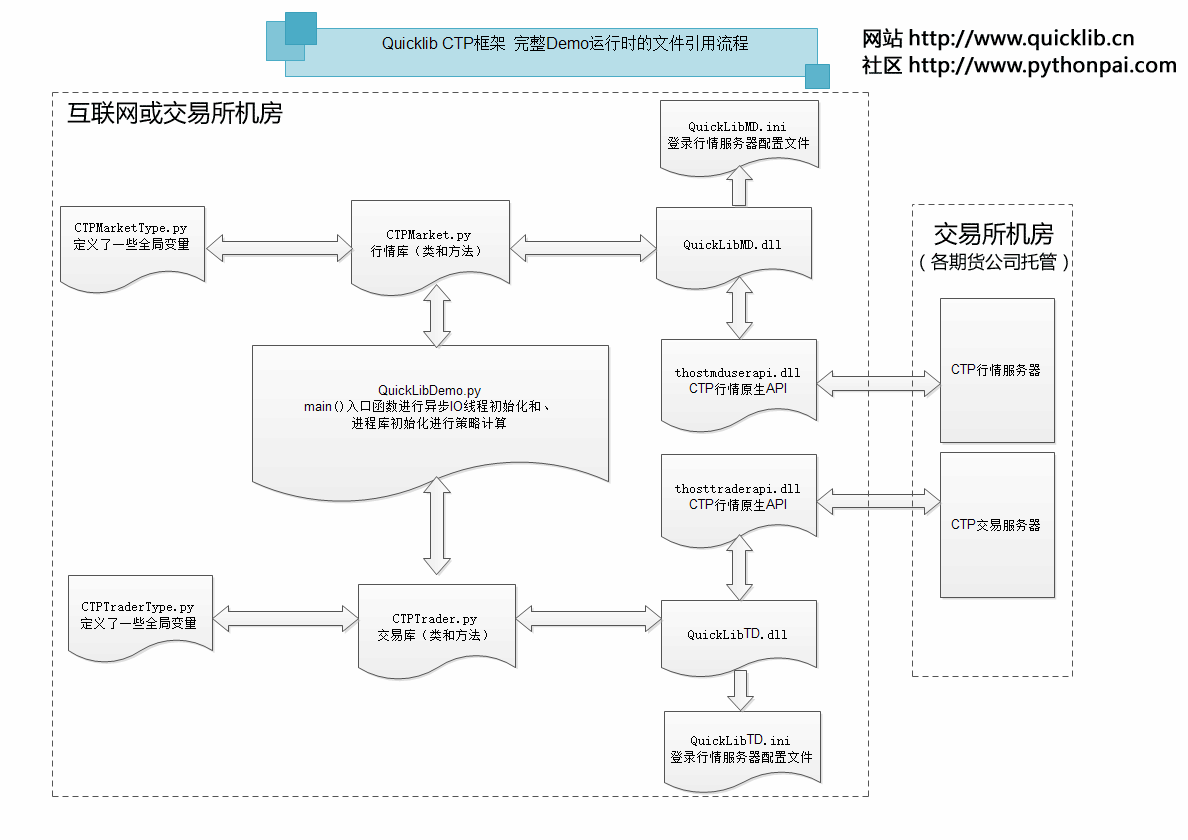

我们先来谈谈为什么要做架构设计。
一个简单的程序，我们一个人就可以完成，那是不需要怎么设计的。
而需要多人协同完成的大型程序，怎么协调各自的工作和代码呢？
这就需要一份软件工程的设计图纸，这个图纸，就是架构设计图。
正如造一栋楼，需要楼房设计图，每个工人按照设计图，
找到自己的负责的部分，完成好自己的部分。
然后再将各自的部分组装起来。
而架构设计图就充当了楼房设计图的角色。

然后我们来介绍一下架构设计的工具。
架构设计的语言是UML，对应的工具有好几种，
其中，我觉得较好用的韩国的StarUML。

那么我们看看，架构设计的步骤：
1. 用例建模
2. 用例分析
3. 设计

### 8.4.1 用例建模
用例建模主要分四步：
1. 业务建模：搞清楚业务是什么样的
2. 用例建模：获取原始需求、识别参与者、识别用例、绘制用例图
3. 编写文档
4. 重构用例：基于业务、参与者、开发团队、发布情况分包与分优先级

### 8.4.2 用例分析
用例分析是连接需求与设计的重要部分，连接着业务域和技术域。
它主要使用业务语言，理想化的实现用例，
不考虑技术细节，侧重系统的主要部分，
对非功能需求不作深入分析。它主要分四步：
1. 以用例驱动迭代开发：利用早期迭代建立架构
2. 架构分析：定义系统的备选架构，确定分析机制，提取关键抽象
3. 构造用例实现：识别分析类、分析交互、完成类图
4. 定义分析类：从系统角度而非用例角度定义类

实际上，这四步是循环穿插进行的，并没有绝对的先后顺序，读者应灵活使用。

### 8.4.3 设计
设计应遵守以下原则：
1. Liskov替换原则
2. 开放封闭原则
3. 单一职责原则
4. 接口隔离原则
5. 依赖倒置原则

常见的一些设计方法，被人们总结成了二十多各设计模式，如工厂模式等。
这块展开讲的话可以写一整本书，故我们不赘述，由读者自己去查资料。
然后，做好架构设计和构件设计，从分级机制到设计机制，
定义运行时的架构，描述系统部署。

总之，就是把用例分析的结果翻译成程序语言。
这一块工作量很大，但也是很重要的。
